# Part I: Introduction to Inverse Problems

Welcome to the tutorial to the course **"Regularization in Image Reconstruction: From Model to Data Driven Methods"**! ☀

Image reconstruction is a so-called inverse problem where we want to reconstruct an image from some (noisy) measurement data.

In the first part, we will fix the notation of our inverse problem, see some typical applications and find out what can go wrong with a naive inversion. 

## Notation
Each inverse problem is connected to a forward problem. The forward problems we will look at can be described by a **linear forward operator** $A$ that maps the **ground truth data** $x$ to a **measurement** $y^{\delta}$ which is additionally corrupted by some unknown **noise $\epsilon$**. We thus write 
$$y^{\delta} = Ax + \epsilon.$$
The subscript $\delta$ indicates that the noise $\epsilon$ is bounded by a **noise level** $\delta > 0$ in some way. We will bound the norm of the noise like
$$ \| \epsilon \| \leq \delta.$$

## Examples

Before we start with the hands on examples, we have to import some basic Python packages and load our first example image: a modern version of the famous cameraman.

In [1]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display
import operators # the operator package is a custom package which contains all the operators we will need for this tutorial

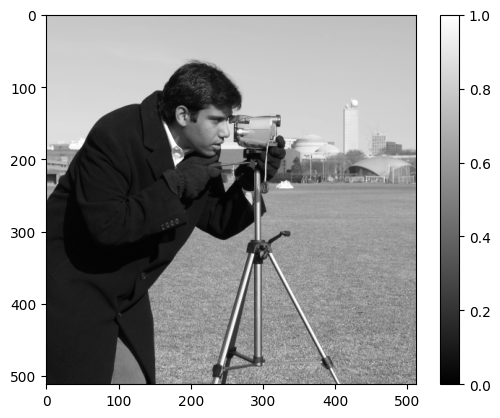

In [2]:
img = ski.img_as_float(ski.data.camera())
plt.imshow(img, cmap='gray')
plt.colorbar()

### <span style="color:cornflowerblue"> Example 1:  Color Negation </span>
Looking at the colorbar next to the image we see that its grey values are included in the interval $[0,1]$. We can produce the so-called **negative image** by negating its grey values.

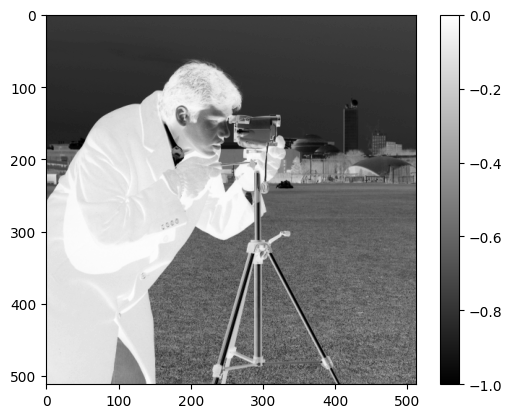

In [3]:
# forward operator for color negation
def negate_colors(img):
    return -img

# compute the negative image of our example image
negative = negate_colors(img)

plt.imshow(negative, cmap='gray')
plt.colorbar()

### &#128221; <span style="color:darkorange">Task 1.1</span>
#### Which forward operator $A$ describes the color negation problem?

### &#128221; <span style="color:darkorange">Task 1.2</span>
#### Complete the following function which inverts the color negation, i.e., takes a negative image as an input and returns the corresponding positive image.

In [4]:
def invert_color_negation(negative):
    positive = -negative#None #TODO [subsitute "None" by your own code] 
    return positive

#### Let's see if it works:

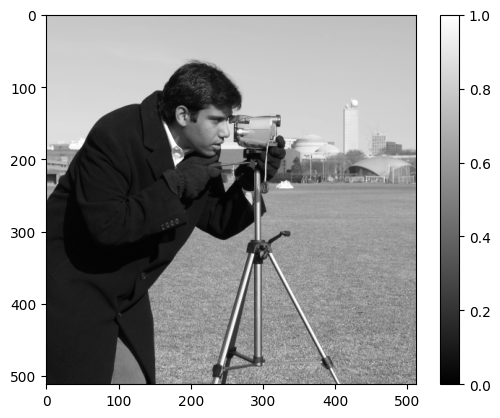

In [5]:
positive = invert_color_negation(negative)

plt.imshow(positive, cmap='gray')
plt.colorbar()

### <span style="color:cornflowerblue"> Example 2:  Computed Tomography </span>

Computed Tomography scans are a popular way to obtain internal images of the body. Roughly speaking, it works by sending X-rays through the body from different directions. While travelling through the body, the X-rays are damped depending on the densities of the materials they pass through. This intensity decay is then measured on the opposite side of the body. The collection of all measurements is called **sinogram**. 

The linear operator that is used to describe the scan is called the Radon Transform and was studied by Johann Radon way before it was used in practice!

Let's look at an exemplary CT scan of the [Shepp-Logan phantom](https://en.wikipedia.org/wiki/Shepp–Logan_phantom)!

In [9]:

phantom = ski.img_as_float(ski.data.shepp_logan_phantom())
theta = np.linspace(0,180, endpoint = False, num=400)
R = operators.Radon(theta)
sinogram =  R(phantom)
ray_pos = np.arange(20, 400, step=40)

def plot_at_angle(angle):
    deg = 180/400*angle
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    rot = ski.transform.rotate(phantom, deg)
    rot[:,ray_pos] = 0.5
    rot[:,ray_pos+1] = 1
    rot[:,ray_pos+2] = 0.5
    projection = sinogram[:,angle]
    sino = sinogram[:,:angle+1]
    axs[0].imshow(rot, cmap = 'gray');
    axs[0].tick_params(bottom = False, left = False)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title('Source')
    axs[0].set_xlabel('Detector')
    axs[1].plot(np.arange(400), projection);
    axs[1].set_ylim([0,0.4]);
    axs[1].set_title('Measurement at '+str(deg)+'$^{\circ}$')
    axs[1].set_xlabel('position')
    axs[1].set_ylabel('intensity decay')
    axs[2].imshow(sino, cmap = 'gray');
    axs[2].set_xlim([0,400])
    axs[2].set_xticks([0,100,200,300,400], ['$0^{\circ}$', '$45^{\circ}$', '$90^{\circ}$', '$135^{\circ}$', '$180^{\circ}$'])
    axs[2].set_xlabel('angle')
    axs[2].set_ylabel('position')
    
    

slider = widgets.IntSlider(min = 0, max = 399, step = 10, value = 0, continuous_update = True)
interactive_plot = interactive(plot_at_angle, angle = slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='angle', max=399, step=10), Output()), _dom_classes=('wid…

## Naive Inversion

Recall our problem $y^{\delta} = Ax + \epsilon$. Since $\epsilon$ is small, we could simply ignore it and compute our solution $\hat{x}$ as
$$ "\hat{x} = A^{-1} y^{\delta} "$$

This is already problematic as it can happen that
* $A^{-1} y^\delta$ does not exist: there doesn't exist any ground truth data $x$ that generates the measurement $y^\delta$.
* $A^{-1} y^\delta$ is not well-defined: there exist multiple $x$ that generate the same measurement $y^\delta$.

However, we can circumvent both of these issues rather easily.
Finding a solution can be relaxed by considering all least-squares solutions, i.e., all
$$ \hat{x} \in \operatorname{sol} = \operatorname*{arg \ min}_{x} \{\|Ax- y^\delta\|^2 \}.$$
If the set of least-squares solutions contains more than one element, we choose the solution which is optimal in some sense, for example the minimum norm solution $x^*$, i.e.,
$$ x^* = \operatorname*{arg\ min}_{\hat{x} \in \operatorname{sol}} \{\|\hat{x}\|^2\}. $$


### Null-space Problems
We will call the problem of deciding which solution to choose a **null-space problem**. The minimum norm solution might not be ideal for all applications. Let's see what it looks like for limited angle CT. 

In [7]:
def plot_lact(idx):
    angle = 399-idx
    deg = 180/400*angle
    lact_sino = sinogram[:,:angle+1]
    R_lact = operators.Radon(theta[:angle+1])
    reco = R_lact.inv(lact_sino)
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    axs[0].imshow(lact_sino, cmap='gray')
    axs[0].set_xlim([0,400])
    axs[0].set_xticks([0,100,200,300,400], ['$0^{\circ}$', '$45^{\circ}$', '$90^{\circ}$', '$135^{\circ}$', '$180^{\circ}$'])
    axs[0].set_xlabel('angle')
    axs[0].set_ylabel('position')
    axs[0].set_title('Sinogram of a scan of '+str(deg)+ ' degrees')
    axs[1].imshow(reco, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title('Reconstruction')

slider2 = widgets.IntSlider(min = 0, max = 399, step = 30, value = 0, continuous_update = True)
interactive_plot2 = interactive(plot_lact, idx = slider2)
display(interactive_plot2)

interactive(children=(IntSlider(value=0, description='idx', max=399, step=30), Output()), _dom_classes=('widge…

### Instability
Another, more subtle problem is **instability**. The solution operator is called instable if small measurements errors cause incontrollably large reconstruction errors. The decision if the reconstruction error is controllable or not is not obvious: Once a problem is described in fixed finite dimensions (i.e., discretized) all linear reconstruction operators are continuous and thus mathematically stable by definition. The instability will only show if we try to generalize the same reconstruction approach to different dimensions.

### &#128221; <span style="color:darkorange"> Task 1.3</span>
#### Complete the following script that computes the reconstruction error for several noisy measurements in different dimensions for both, color negation and computed tomography.
To save time, you can try it out for 'dims=[200]' first until everything runs without errors and then change it back to 'dims = [200, 300, 400, 500, 600, 700, 800]'

In [8]:
dims = [200, 300, 400, 500, 600, 700, 800]

# store all results for visualization:
negatives_noisy = [] # list to collect noisy negatives
img_recos = [] # list to collect image reconstructions
img_err = np.zeros(len(dims)) # array to store the reconstruction errors for the color negation problem

sinograms_noisy = [] # list to collect noisy sinograms
phantom_recos = [] # list to collect phantom reconstructions
phantom_err = np.zeros(len(dims)) # array to store the reconstruction errors for the ct problem

for i, dim in enumerate(dims): # iterate over the various dimensions
    
    epsilon = np.random.normal(scale=0.1, size=(dim,dim))  # generate the same random noise for both problems

    #############################################################################################
    ############################# COLOR NEGATION PROBLEM ########################################

    # generate x, Ax + epsilon and x*
    img_res = ski.transform.resize(img, (dim, dim)) # resize the cameraman image (x)

    ###### TODO's start here #####

    negative_noisy = negate_colors(img_res) + epsilon #None #TODO negative_noisy should be the negative corresponding to img_res which is then corrupted by noise (Ax + epsilon)
    img_reco = invert_color_negation(negative_noisy) #None #TODO use your function 'invert_color_negation' here to reconstruct the original image from 'negative_noisy' (x*)

    ###### TODO's end here #######

    # store results
    negatives_noisy.append(negative_noisy) # store the noisy negative
    img_recos.append(img_reco) # store reconstruction
    img_err[i] = np.linalg.norm(img_reco - img_res)/dim # store L2-error

    ##############################################################################################
    ###################################### CT PROBLEM ############################################

    # generate x, Ax + epsilon and x*
    phantom_res = ski.transform.resize(phantom, (dim, dim)) # resize the shepp-logan phantom and scale grey values for technical reasons (x)
    theta_res = np.linspace(0,180, endpoint = False, num=dim)  # fix the angles that should be used for CT scan
    R_res = operators.Radon(theta_res)
    
    ###### TODO's start here #####
    
    sinogram_noisy = R_res(phantom_res) + epsilon #None #TODO sinogram_noisy should be 'R_res' of 'phantom_res' which is then corrupted by noise (Ax + epsilon)
    phantom_reco = R_res.inv(sinogram_noisy) #None #TODO use 'R_res.inv' to reconstruct the phantom from 'sinogram_noisy' (x*)
    
    ###### TODO's end here #######

    # store results
    sinograms_noisy.append(sinogram_noisy)
    phantom_recos.append(phantom_reco)
    phantom_err[i] = np.linalg.norm(phantom_reco - phantom_res)/dim

    ################################################################################################
    ################################################################################################

KeyboardInterrupt: 

### &#128221; <span style="color:darkorange"> Task 1.4</span>
#### Use the following slider (which uses your code from above) to decide if the problems are rather stable or instable.

In [ ]:
def plot_resolutions(idx):
    
    fig = plt.figure(figsize=(16,8))
    axs00 = plt.subplot2grid((2,3), (1,0))
    axs01 = plt.subplot2grid((2,3), (1,1))
    axs10 = plt.subplot2grid((2,3), (0,0))
    axs11 = plt.subplot2grid((2,3), (0,1))
    axsplot = plt.subplot2grid((2,3), (0,2), rowspan=2)

    im00 = axs00.imshow(negatives_noisy[idx], cmap='gray', vmin = -1.5, vmax = 0.5)
    axs00.axis('off')
    axs00.set_title('Noisy Negative')
    plt.colorbar(im00, ax = axs00)
    im01 = axs01.imshow(img_recos[idx], cmap='gray', vmin = -0.5, vmax = 1.5)
    axs01.axis('off')
    axs01.set_title('Reconstructed Image')
    plt.colorbar(im01, ax = axs01)

    im10 = axs10.imshow(sinograms_noisy[idx], cmap='gray', vmin = -0.5, vmax =0.7)
    axs10.axis('off')
    axs10.set_title('Noisy Sinogram')
    plt.colorbar(im10, ax = axs10)
    im11 = axs11.imshow(phantom_recos[idx], cmap='gray')
    axs11.axis('off')
    axs11.set_title('Reconstructed Phantom')
    plt.colorbar(im11, ax = axs11)

    axsplot.plot(dims[:idx+1], phantom_err[:idx+1], alpha=0.9)
    axsplot.scatter(dims[idx], phantom_err[idx], label='CT')
    axsplot.plot(dims[:idx+1], img_err[:idx+1], alpha=0.5)
    axsplot.scatter(dims[idx], img_err[idx], label='Color Negation')
    axsplot.set_title('Reconstruction Error')
    axsplot.set_xlabel('Dimension')
    axsplot.set_xlim([180,820])
    axsplot.set_xticks(dims)
    axsplot.set_ylim([0,1.6])
    axsplot.legend(loc='upper left')


    plt.suptitle('Resolution '+str(dims[idx]) + r'$\times$' + str(dims[idx]))


slider3 = widgets.IntSlider(min = 0, max = len(dims)-1, step = 1, value = 0, continuous_update = True)
interactive_plot3 = interactive(plot_resolutions, idx = slider3)
display(interactive_plot3)

interactive(children=(IntSlider(value=0, description='idx', max=6), Output()), _dom_classes=('widget-interact'…